In [1]:
import pyspark
import numpy as np
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, rand, row_number
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler
import matplotlib.pyplot as plt

In [2]:
from pyspark.sql.types import DoubleType
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
mirai_devices = ['danmini_doorbell', 'ecobee_thermostat', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

benign = ['danmini_doorbell', 'ecobee_thermostat', 'ennio_doorbell', 'philips_B120N10_baby_monitor', 
            'provision_PT_737E_security_camera', 'provision_PT_838_security_camera', 'samsung_SNH_1011_N_webcam',
            'simplehome_XCS_1002_WHT_security_camera', 'simplehome_XCS_1003_WHT_security_camera']

mirai_attacks = ['ack', # automatic scan for vulnerable devices
                 'scan', # ack flood
                 'syn', # syn flood
                 'udp', # udp flood
                 'udpplain'] # optimized udp flood

In [4]:
first = True
mirai_data = None
for device in mirai_devices:
    for attack in mirai_attacks:
        if first:
            mirai_data = spark.read.option("inferSchema",True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/mirai_attacks/{attack}.csv')
            mirai_data = mirai_data.withColumn("label", lit(attack))
            first = False
        else:
            to_add = spark.read.option("inferSchema",True)\
                .option("header", True).csv(f'../data/n_balo_t/{device}/mirai_attacks/{attack}.csv')
            to_add = to_add.withColumn("label", lit(attack))
            mirai_data = mirai_data.union(to_add)
first = True
benign_data = None
for device in benign:
    if first:
        benign_data = spark.read.option("inferSchema",True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        first = False
    else:
        to_add = spark.read.option("inferSchema",True)\
            .option("header", True).csv(f'../data/n_balo_t/{device}/benign_traffic.csv')
        benign_data = benign_data.union(to_add)
benign_data = benign_data.withColumn('label', lit("benign"))

mirai_data = mirai_data.union(benign_data)

print(f'total data for prediciton modeling = {mirai_data.count()}')

total data for prediciton modeling = 4224334


In [5]:
cols = mirai_data.columns
new_cols = [str(i) for i in range(len(cols))]
mirai_data = mirai_data.toDF(*new_cols)
mirai_data = mirai_data.withColumnRenamed('115', 'label')

In [6]:
def reg_kmeans(data, min_k=2, max_k=5):
    feature_list = []
    for col in data.columns:
        if col == 'label':
            continue
        else:
            feature_list.append(col)
            
    # set up feature and labels as input and output
    asmblr = VectorAssembler(inputCols=feature_list, outputCol="features")
        
    assembled_data=asmblr.transform(data)
    
    scale=StandardScaler(inputCol='features',outputCol='standardized')
    data_scale=scale.fit(assembled_data)
    data_scale_output=data_scale.transform(assembled_data)
    
    silhouette_score=[]
    
    evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                    metricName='silhouette', distanceMeasure='squaredEuclidean')
    
    highest = (0, None)
    
    for i in range(min_k, max_k):
        KMeans_algo=KMeans(featuresCol='standardized', k=i)
        
        KMeans_fit=KMeans_algo.fit(data_scale_output)
        
        output=KMeans_fit.transform(data_scale_output)
        
        score=evaluator.evaluate(output)
        
        if highest[0] < score:
            highest = (score, output)
        
        silhouette_score.append(score)
        
        print("Silhouette Score:",score)
    
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(min_k, max_k),silhouette_score)
    ax.set_xlabel('k')
    ax.set_ylabel('cost')
        
    return highest

In [7]:
big_sample, small_sample = mirai_data.randomSplit([0.95, 0.05])
print(small_sample.count())

210867


Silhouette Score: 0.4929274192397567
Silhouette Score: 0.5135661388393621
Silhouette Score: 0.5230902748734655
Silhouette Score: 0.49231435688050673
Silhouette Score: 0.6026911952234411


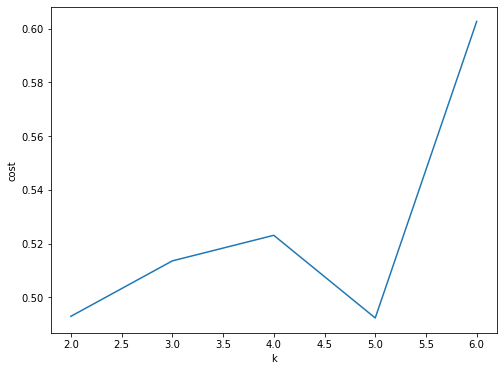

In [10]:
predictions = reg_kmeans(small_sample, 2, 7)